In [1]:
import os
from pathlib import Path

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import omero.clients
import seaborn as sns
import scanpy as sc
import tifffile
from skimage.segmentation import find_boundaries
from skimage.transform import resize
from omero.gateway import BlitzGateway

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mip.utils as utils

## load in data

In [179]:
backup_dir = '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/annotation_backups'


In [8]:
# os.environ["OMERO_PASSWORD"] = ''

In [9]:
group = 'HTAN'
project = 'CODEX_initial'
username = 'estorrs'
password = os.environ["OMERO_PASSWORD"]
host = 'htan-imaging.wucon.wustl.edu'
port = '4064'

In [10]:
conn = BlitzGateway(username, password, host=host, port=port,
                    secure=True, group=group)
conn.connect()

True

In [11]:
project = next(iter(conn.getObjects("Project", attributes={"name": project})))

In [12]:
# list out all images in the project
name_to_img = {}
for dataset in project.listChildren():
    for img in dataset.listChildren():
        name_to_img[f'{dataset.getName()} | {img.getName()}'] = img
sorted(name_to_img.keys())

['E16.5_female_section1_04272023 | E16.5_female_section1_04272023',
 'E16.5_female_section2_04272023 | E16.5_female_section2_04272023',
 'E16.5_male_section1_04272023 | E16.5_male_section1_04272023',
 'E16.5_male_section2_04272023 | E16.5_male_section2_04272023',
 'HT110B1_S1H4 | HT110B1_S1H4',
 'HT112C1 | HT112C1',
 'HT171B1-S1H9A1-4_04192023 | HT171B1-S1H9A1-4_04192023',
 'HT171B1_S1H1A1_11182022 | HT171B1_S1H1A1_11182022',
 'HT171B1_S1H1A1_12022022 | HT171B1_S1H1A1_12022022',
 'HT171B1_S1H1A1_20221122 | HT171B1_S1H1A1_20221122',
 'HT171B1_S1H1A4_11182022 | HT171B1_S1H1A4_11182022',
 'HT171B1_S1H1A4_12022022 | HT171B1_S1H1A4_12022022',
 'HT171B1_S1H1A4_20221205 | HT171B1_S1H1A4_20221205',
 'HT206B1_Ctrl_from_Marrow_179 | HT206B1_Ctrl_from_Marrow_179',
 'HT206B1_H1 | HT206B1_H1',
 'HT206B1_H1_06252022 | HT206B1_H1_06252022',
 'HT206B1_S1H2L4_20221020 | HT206B1_S1H2L4_20221020',
 'HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028',
 'HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023',


In [13]:
names = [
    'HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023',
    'HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023',
    'HT397B1_U12_03172023 | HT397B1_U12_03172023',
    'HT397B1_U2_03162023 | HT397B1_U2_03162023',
]

In [15]:
channel_thresholds = {}
for name in names:
    img = name_to_img[name]
    rendering_defs = img.getAllRenderingDefs()
    channel_metadata = rendering_defs[0]['c']
    thresholds = [c['start'] for c in channel_metadata]
    
    if np.asarray(thresholds).sum() == 0:
        print('warning: all thresholds are zero. maybe they are not set for this image?', name)

    channel_thresholds[name] = thresholds
channel_thresholds

{'HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023': [0.0,
  10.0,
  0.0,
  0.0,
  0.0,
  18.0,
  0.0,
  8.0,
  234.0,
  0.0,
  0.0,
  8.0,
  0.0,
  0.0,
  10.0,
  15.0,
  10.0,
  0.0,
  10.0,
  0.0,
  0.0,
  20.0,
  0.0,
  10.0,
  0.0,
  0.0,
  0.0],
 'HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023': [0.0,
  10.0,
  0.0,
  0.0,
  0.0,
  50.0,
  0.0,
  8.0,
  231.0,
  0.0,
  0.0,
  8.0,
  0.0,
  10.0,
  40.0,
  20.0,
  0.0,
  0.0,
  0.0,
  20.0,
  0.0,
  10.0,
  0.0,
  0.0,
  0.0],
 'HT397B1_U12_03172023 | HT397B1_U12_03172023': [0.0,
  10.0,
  0.0,
  0.0,
  0.0,
  50.0,
  0.0,
  0.0,
  221.0,
  0.0,
  0.0,
  8.0,
  0.0,
  12.0,
  13.0,
  10.0,
  0.0,
  0.0,
  0.0,
  20.0,
  0.0,
  10.0,
  0.0,
  0.0,
  0.0],
 'HT397B1_U2_03162023 | HT397B1_U2_03162023': [0.0,
  10.0,
  0.0,
  0.0,
  0.0,
  46.0,
  0.0,
  10.0,
  224.0,
  0.0,
  0.0,
  8.0,
  0.0,
  10.0,
  10.0,
  10.0,
  0.0,
  0.0,
  0.0,
  20.0,
  0.0,
  10.0,
  0.0,
  0.0,
  0.0]}

In [17]:
fps = sorted(utils.listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/', regex=r'ome.tiff$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_2/HT365B1_S1H1.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_2/HT271B1_S1H3A5.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1_S1H1A3U31_04062023.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_2/HT397B1_S1H1A3U22_04122023.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT171B1-S1H9A1-4_04192023.ome.tiff',
 '/diskmnt/Projects/Users

In [42]:
fps = sorted(utils.listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/', regex=r'level_3.*.tif$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_3/segmentation/cell_segmentation.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_3/segmentation/nuclei_segmentation.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_3/segmentation/cell_segmentation.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_3/segmentation/nuclei_segmentation.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_3/segmentation/cell_segmentation.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_3/segmentation/nuclei_segmentation.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_3/segmentation/cell_segmentation.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_dat

In [43]:
mapping = {
    'HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023': {
        'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_2/HT397B1_S1H1A3U22_04122023.ome.tiff',
        'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_3/segmentation/cell_segmentation.tif'
    },
    'HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023': {
        'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1_S1H1A3U31_04062023.ome.tiff',
        'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_3/segmentation/cell_segmentation.tif'
    },
    'HT397B1_U12_03172023 | HT397B1_U12_03172023': {
        'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff',
        'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_3/segmentation/cell_segmentation.tif'
    },
    'HT397B1_U2_03162023 | HT397B1_U2_03162023': {
        'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff',
        'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_3/segmentation/cell_segmentation.tif'
    }
}


In [180]:
def generate_feature_table(ome_fp, seg_fp, thresholds):
    channels, imgs = utils.extract_ome_tiff(ome_fp, as_dict=False)
    assert len(channels) == len(thresholds)
    
    seg = tifffile.imread(seg_fp)
    thresholds = np.asarray(thresholds) # make sure numpy
    
    masks = rearrange(
        rearrange(imgs, 'c h w -> h w c') > thresholds,
        'h w c -> c h w')
    
    props = regionprops(seg)
    
    data = []
    for i, prop in enumerate(props):
        label = i + 1
        row = []
        r1, c1, r2, c2 = prop['bbox']

        area = prop['area']
        seg_tile = seg[r1:r2, c1:c2]
        imgs_tile = imgs[..., r1:r2, c1:c2]
        masks_tile = masks[..., r1:r2, c1:c2]

        cell_mask = seg_tile==label

        row = [label, prop['centroid'][0], prop['centroid'][1], r1, c1, r2, c2, area]
        for j in range(imgs_tile.shape[0]):
            img, mask = imgs_tile[j], masks_tile[j]
            counts = (cell_mask & mask).sum()
            row.append(counts / area)
            
            intensity = img[cell_mask].mean()
            row.append(intensity)

        data.append(row)

    cols = ['label', 'row', 'col', 'bbox-r1', 'bbox-r2', 'bbox-c1', 'bbox-c2', 'area']
    for c in channels:
        for identifier in ['fraction', 'intensity']:
            cols.append(f'{c}_{identifier}')
    df = pd.DataFrame(data=data, columns=cols)
    return df


In [181]:
name_to_features = {}
for name in mapping.keys():
    print(name)
    df = generate_feature_table(mapping[name]['img'], mapping[name]['seg'], channel_thresholds[name])
    name_to_features[name] = df

HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023
HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023
HT397B1_U12_03172023 | HT397B1_U12_03172023
HT397B1_U2_03162023 | HT397B1_U2_03162023


In [202]:
combined = None
for name, df in name_to_features.items():
    df['name'] = name
    if combined is None:
        combined = df
    else:
        combined = pd.concat((combined, df))
combined

,label,row,col,bbox-r1,bbox-r2,bbox-c1,bbox-c2,area,DAPI_fraction,DAPI_intensity,...,COX6c (D)_fraction,COX6c (D)_intensity,CK19_fraction,CK19_intensity,PLAT/tPA (D)_fraction,PLAT/tPA (D)_intensity,sample,name,CD20-(D)_fraction,CD20-(D)_intensity
0,1,1508.894809,11116.904372,1495,11103,1524,11132,732,1.0,7.670765,...,0.053279,0.057377,0.282787,0.398907,0.169399,0.198087,HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22...,HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22...,NaN,NaN
1,2,1644.577593,10032.147718,1626,10010,1670,10055,1205,1.0,27.480498,...,0.410788,0.876349,0.806639,8.496266,0.617427,2.819087,HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22...,HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22...,NaN,NaN
2,3,1653.120066,10056.605263,1636,10043,1670,10073,608,1.0,39.210526,...,0.524671,1.776316,0.914474,10.824013,0.838816,4.891447,HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22...,HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22...,NaN,NaN
3,4,1653.010502,10198.464411,1638,10181,1671,10217,857,1.0,12.646441,...,0.068845,0.092182,0.943991,5.123687,0.997666,3.943991,HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22...,HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22...,NaN,NaN
4,5,1671.722566,9939.953246,1645,9907,1705,9971,2588,1.0,42.124034,...,0.511592,1.437403,0.848532,12.665765,0.656105,2.349691,HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22...,HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127191,127192,16406.805492,9585.729977,16394,9573,16420,9601,437,1.0,12.411899,...,0.585812,1.169336,0.958810,25.990847,0.851259,2.405034,HT397B1_U2_03162023 | HT397B1_U2_03162023,HT397B1_U2_03162023 | HT397B1_U2_03162023,0.0,1.681922
127192,127193,16411.031792,9567.078035,16402,9554,16424,9583,346,1.0,11.838150,...,0.410405,0.621387,1.000000,15.742775,0.760116,1.531792,HT397B1_U2_03162023 | HT397B1_U2_03162023,HT397B1_U2_03162023 | HT397B1_U2_03162023,0.0,0.852601
127193,127194,16415.748408,9540.305732,16403,9527,16430,9555,628,1.0,10.035032,...,0.452229,0.679936,0.998408,25.100318,0.757962,1.549363,HT397B1_U2_03162023 | HT397B1_U2_03162023,HT397B1_U2_03162023 | HT397B1_U2_03162023,0.0,0.743631
127194,127195,16426.708984,9564.128906,16414,9551,16438,9580,512,1.0,12.521484,...,0.455078,0.759766,1.000000,21.771484,0.804688,1.888672,HT397B1_U2_03162023 | HT397B1_U2_03162023,HT397B1_U2_03162023 | HT397B1_U2_03162023,0.0,0.832031


In [203]:
# fig, ax = plt.subplots(figsize=(20, 20))

# xy = combined[combined['sample']=='HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023']
# xy = xy[xy['Pan-Cytokeratin_fraction']>.1][['col', 'row']]
# sns.scatterplot(data=xy, x='col', y='row', size=.1, ax=ax)
# plt.axis('equal')

In [204]:
gating_strategy = [
    {
        'name': 'Epithelial',
        'strategy': [
            {'channel': 'Pan-Cytokeratin', 'value': .1, 'direction': 'pos'}
        ],
    },
    {
        'name': 'Treg',
        'strategy': [
            {'channel': 'CD45 (D)', 'value': .1, 'direction': 'pos'},
            {'channel': 'FoxP3', 'value': .1, 'direction': 'pos'}
        ],
    },
    {
        'name': 'CD8 T cell',
        'strategy': [
            {'channel': 'CD45 (D)', 'value': .1, 'direction': 'pos'},
            {'channel': 'CD8', 'value': .1, 'direction': 'pos'}
        ],
    },
    {
        'name': 'B cell',
        'strategy': [
            {'channel': 'CD45 (D)', 'value': .1, 'direction': 'pos'},
            {'channel': 'CD20-(D)', 'value': .1, 'direction': 'pos'}
        ],
    },
    {
        'name': 'Endothelial',
        'strategy': [
            {'channel': 'CD31', 'value': .1, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Immune',
        'strategy': [
            {'channel': 'CD45 (D)', 'value': .1, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Stroma',
        'strategy': [
            {'channel': 'SMA-(D)', 'value': .1, 'direction': 'pos'},
        ],
    },
]

In [218]:
import json
json.dumps(gating_strategy)

'[{"name": "Epithelial", "strategy": [{"channel": "Pan-Cytokeratin", "value": 0.1, "direction": "pos"}]}, {"name": "Treg", "strategy": [{"channel": "CD45 (D)", "value": 0.1, "direction": "pos"}, {"channel": "FoxP3", "value": 0.1, "direction": "pos"}]}, {"name": "CD8 T cell", "strategy": [{"channel": "CD45 (D)", "value": 0.1, "direction": "pos"}, {"channel": "CD8", "value": 0.1, "direction": "pos"}]}, {"name": "B cell", "strategy": [{"channel": "CD45 (D)", "value": 0.1, "direction": "pos"}, {"channel": "CD20-(D)", "value": 0.1, "direction": "pos"}]}, {"name": "Endothelial", "strategy": [{"channel": "CD31", "value": 0.1, "direction": "pos"}]}, {"name": "Immune", "strategy": [{"channel": "CD45 (D)", "value": 0.1, "direction": "pos"}]}, {"name": "Stroma", "strategy": [{"channel": "SMA-(D)", "value": 0.1, "direction": "pos"}]}]'

In [224]:
import imagecodecs
imagecodecs.version()

'imagecodecs-2021.8.26, cython-0.29.24, numpy-1.21.6, numpy_abi-0x1000009.13, imcd-2021.8.26, avif-n/a, bitshuffle-0.3.5, blosc2-n/a, brotli-1.0.9, brunsli-0.1, c-blosc-1.21.0, cfitsio-3.47, charls-2.2.0, giflib-5.2.1, imcd-2021.8.26, jpeg12-n/a, jpegsof3-2020.12.22, jpegxl-n/a, jxrlib-1.1, lerc-3.0.0, libaec-1.0.5, libbzip2-1.0.8, libdeflate-1.8, libjpeg-9.4, liblj92-2014, liblzf-1.5, liblzma-5.2.5, libpng-1.6.37, libtiff-4.2.0, libwebp-1.2.2, lz4-1.9.3, openjpeg-2.4.0, pg_lzcompress-13.2, snappy-1.1.7, zfp-0.5.5, zlib-1.2.13, zlibng-n/a, zopfli-1.0.3, zstd-1.4.9'

In [205]:
cell_types = np.asarray(['Unlabeled'] * combined.shape[0], dtype=object)
for d in gating_strategy:
    is_valid = cell_types=='Unlabeled'
    mask = np.ones_like(cell_types, dtype=np.bool)
    for strategy in d['strategy']:
        channel, val = strategy['channel'], strategy['value']
        if strategy['direction'] == 'pos': 
            m = combined[f'{channel}_fraction'] >= val
        else:
            m = combined[f'{channel}_fraction'] < val
        mask = mask & m
    mask = mask & is_valid
    cell_types[mask] = d['name']

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [206]:
cell_types

array(['Unlabeled', 'Epithelial', 'Epithelial', ..., 'Epithelial',
       'Epithelial', 'Epithelial'], dtype=object)

In [207]:
combined['cell_type'] = cell_types

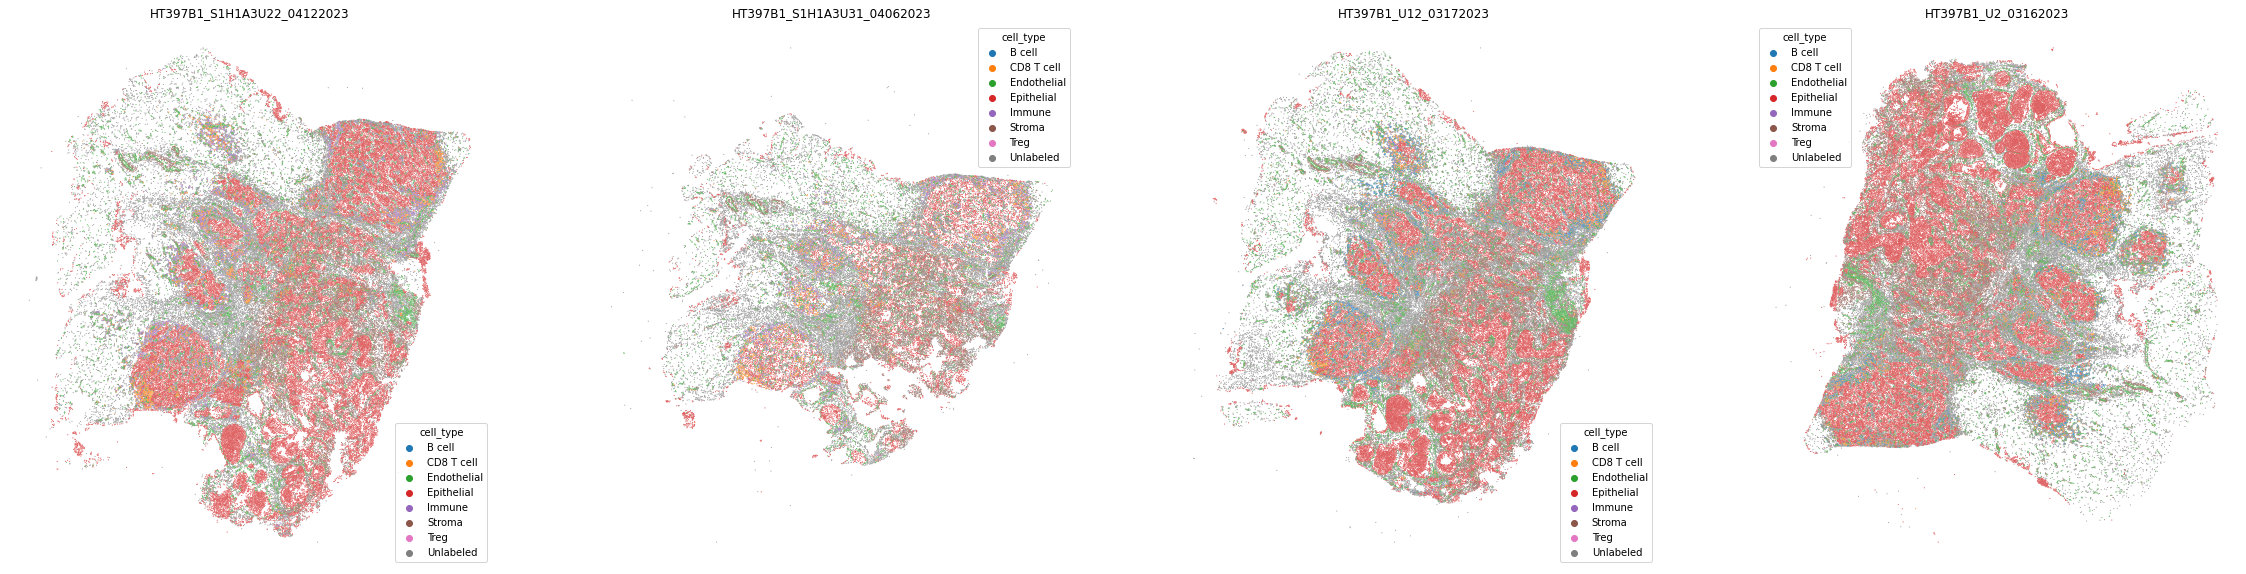

In [208]:
fig, axs = plt.subplots(ncols=4, figsize=(40, 10))

for name, ax in zip(names, axs):
    f = combined[combined['name']==name]
    sns.scatterplot(data=f, x='col', y='row', hue='cell_type', s=1., hue_order=sorted(set(cell_types)), ax=ax)
    ax.axis('off')
    ax.set_title(name.split(' | ')[0])

In [209]:
combined['omero_dataset'] = [n.split(' | ')[0] for n in combined['name']]
combined['omero_image'] = [n.split(' | ')[1] for n in combined['name']]
combined['row'], combined['col'] = [int(x) for x in combined['row']], [int(x) for x in combined['col']]

In [210]:
combined.to_csv('/diskmnt/Projects/Users/estorrs/sandbox/HT397B1_serial_features.txt', sep='\t', index=False)

In [172]:
import anndata

In [223]:
for name in names:
    print(name)
    f = combined[combined['name']==name]
    
    val_cols = [c for c in f.columns if '_fraction' in c]
    meta = f[[c for c in f.columns if c not in val_cols]]
    meta = meta.set_index('label')
    a = anndata.AnnData(X=f[val_cols].values.astype(np.float32), obs=meta)
    a.var.index = val_cols
    
    a.uns['thresholds'] = channel_thresholds[name]
    a.uns['gating_strategy'] = json.dumps(gating_strategy)
    
    a.obsm['spatial'] = meta[['col', 'row']].values
    
    root = mapping[name]['img'].split('/level_')[0]

    level_4 = os.path.join(root, 'level_4')
    Path(level_4).mkdir(parents=True, exist_ok=True)
    
    identifier = name.split(' | ')[-1]
    a.write_h5ad(os.path.join(level_4, f'{identifier}.h5ad'))
    f.to_csv(os.path.join(level_4, f'{identifier}.txt'), sep='\t')
    

HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023
HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023
HT397B1_U12_03172023 | HT397B1_U12_03172023
HT397B1_U2_03162023 | HT397B1_U2_03162023
